#### 분류평가
- 정확도만으로 불균형한 레이블 데이터 세트에서 평가지표로 사용하기에는 부적합
- 정확도가 가지는 분류 평가 지표로의 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야 함

#### Confusion Matrix(혼동행렬, 오차행렬)
- 이진분류에서 성능 지표로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면 얼마나 혼동될 수 있는지도 함께 보여주는 지표
- 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 보여줌

#### 평가 지표
- TP,FP,FN,TN 예측클래스와 실제 클래스의 Positive 결정 값과 Negative 결정 값의 결합에 따라 결정
- 앞문자 True/False는 예측값과 실제값이 같은가/틀린가를 의미하고 뒤 문자 N/P는 예측 결과값이 부정/긍정을 의미
- 정확도 = (TP + TN) / (TP + TN + FP + FN)
- 정밀도 = TP / (TP + FP) : P로 예측한 것중에서 실제도 P
- 재현율 = TP / (TP + FN) : 실제 P인 것중에서 예측도 P
- F1 = 2 * (정밀도 * 재현율) / (정밀도 + 재현율) : 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼때 높아짐
- 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
- 재현율이 중요 지표인 경우 : 양성 데이터를 음성으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(암진단, 보험사기)
- 정밀도가 더 중요한 지표인 사례 : 스팸 메일 여부를 판단하는 경우로 스팸 메일이 아닌데 스팸 메일로 분류해서 업무 차질 발생.

#### 정밀도 및 재현율 활용 시 유의사항
- 정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능
- 정밀도 100%가 되는 방법 : 확실한 기준이 되는 경우만 P로 예측하고 나머지는 모두 N로 예측 TP/(TP+FP) = 1/(1+0) = 1
- 재현율이 100%가 되는 방법 : 실제 양성 1000명중 30명 TP/(TP + FN) = 30/(30 + 0) = 1
- 분류가 정밀도, 재현율 중 하나에 상대적인 중요도를 부여할 수 있지만 하나만 강조해서는 안됨
- 암 예측 모델에서 재현율을 높인다고 주로 양성만 판정한다면 환자의 불만과 불평이 커지게 됨

## 정밀도와 재현율

In [166]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd


def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df

In [169]:

# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)
X_titanic_df

C:\Users\admin\AppData\Local\Temp/ipykernel_16248/1216502576.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Cabins'] = df3['Cabin'].str[:1]


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,0.014151,5,2
1,1,0,38.000000,1,0,0.139136,2,0
2,3,0,26.000000,0,0,0.015469,5,2
3,1,0,35.000000,1,0,0.103644,2,2
4,3,1,35.000000,0,0,0.015713,4,2
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,0.025374,4,2
887,1,0,19.000000,0,0,0.058556,1,2
888,3,0,21.773973,1,2,0.045771,5,2
889,1,1,26.000000,0,0,0.058556,2,0


In [170]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [195]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[108  10]
 [ 15  46]]
정확도: 0.8603, 정밀도: 0.8214, 재현율: 0.7541


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [196]:
TN=108; FP=10;FN=15;TP=46
print('accuracy :',(TP+TN)/(TP+TN+FP+FN))
print('precision:',TP/(TP+FP))
print('recall:',TP/(TP+FN))
print('F1 SCORE:',2*((TP/(TP+FP)*TP/(TP+FN))/(TP/(TP+FP)+TP/(TP+FN))))

accuracy : 0.8603351955307262
precision: 0.8214285714285714
recall: 0.7540983606557377
F1 SCORE: 0.7863247863247864


## Precision/Recall Trade-off

** predict_proba( ) 메소드 확인 **

In [198]:
print('df Shape : {0}'.format(df.shape))
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])


df Shape : (768, 9)
pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.52395488 0.47604512]
 [0.89069594 0.10930406]
 [0.87793575 0.12206425]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.52395488 0.47604512 0.        ]
 [0.89069594 0.10930406 0.        ]
 [0.87793575 0.12206425 0.        ]]


## ** Binarizer 활용 **

In [90]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


** 분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환 **

In [207]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼 , 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 15  46]]
정확도: 0.8603, 정밀도: 0.8214, 재현율: 0.7541


** 분류 결정 임계값 0.4 기반에서 Binarizer를 이용하여 예측값 변환 **

In [92]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [11 50]]
정확도: 0.8268, 정밀도: 0.7143, 재현율: 0.8197


** 여러개의 분류 결정 임곗값을 변경하면서  Binarizer를 이용하여 예측값 변환 **

In [93]:
th = [0.4, 0.45, 0.50, 0.55, 0.60]

for i in th:
    print('임곗값 :',i)
    pred_proba_1 = pred_proba[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold=i).fit(pred_proba_1) 
    custom_predict = binarizer.transform(pred_proba_1)
    get_clf_eval(y_test , custom_predict)
    print()


임곗값 : 0.4
오차 행렬
[[98 20]
 [11 50]]
정확도: 0.8268, 정밀도: 0.7143, 재현율: 0.8197

임곗값 : 0.45
오차 행렬
[[100  18]
 [ 13  48]]
정확도: 0.8268, 정밀도: 0.7273, 재현율: 0.7869

임곗값 : 0.5
오차 행렬
[[107  11]
 [ 14  47]]
정확도: 0.8603, 정밀도: 0.8103, 재현율: 0.7705

임곗값 : 0.55
오차 행렬
[[111   7]
 [ 15  46]]
정확도: 0.8771, 정밀도: 0.8679, 재현율: 0.7541

임곗값 : 0.6
오차 행렬
[[111   7]
 [ 17  44]]
정확도: 0.8659, 정밀도: 0.8627, 재현율: 0.7213



In [225]:
pred_proba_class1

array([0.47604512, 0.10930406, 0.12206425, 0.13480657, 0.15964559,
       0.13252714, 0.09627786, 0.8115267 , 0.2539835 , 0.64808615,
       0.0997891 , 0.12698114, 0.11560016, 0.09107865, 0.45832582,
       0.14344656, 0.08452345, 0.28515812, 0.2894898 , 0.83999299,
       0.28696564, 0.34614878, 0.14825395, 0.182083  , 0.09145431,
       0.24160208, 0.15950922, 0.05847119, 0.31391985, 0.32224706,
       0.91829342, 0.79572932, 0.12842057, 0.84610232, 0.36533349,
       0.25310831, 0.06263112, 0.61324376, 0.05050148, 0.10310615,
       0.42301785, 0.07732447, 0.82516327, 0.74464126, 0.71617964,
       0.71619688, 0.89578486, 0.31366262, 0.95282569, 0.09148933,
       0.45205265, 0.10184339, 0.1344289 , 0.73624321, 0.36138712,
       0.19504734, 0.23283679, 0.11559447, 0.14992296, 0.462849  ,
       0.31354185, 0.10058551, 0.47904925, 0.6532968 , 0.33491053,
       0.08319643, 0.65729397, 0.57757672, 0.95263778, 0.13810866,
       0.12437178, 0.16505902, 0.10310886, 0.93618231, 0.21898

In [226]:
thr_index 

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135])

In [224]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (141,)
반환된 precisions 배열의 Shape: (142,)
반환된 recalls 배열의 Shape: (142,)
thresholds 5 sample: [0.10310615 0.10310886 0.10846371 0.10930406 0.10942372]
precisions 5 sample: [0.42657343 0.42253521 0.42553191 0.42857143 0.42446043]
recalls 5 sample: [1.         0.98360656 0.98360656 0.98360656 0.96721311]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.15 0.23 0.31 0.43 0.58 0.72 0.85 0.95]
샘플 임계값별 정밀도:  [0.427 0.438 0.496 0.571 0.671 0.746 0.865 0.919 0.955 1.   ]
샘플 임계값별 재현율:  [1.    0.918 0.918 0.918 0.902 0.82  0.738 0.557 0.344 0.115]


141


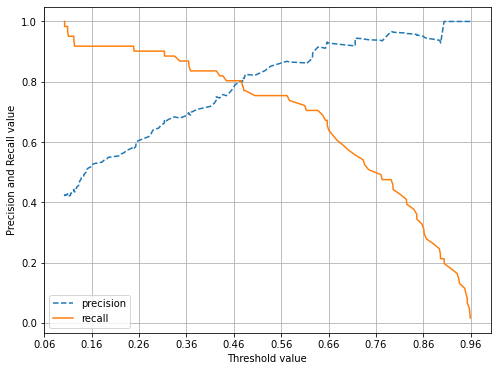

In [227]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):

    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    # print(thresholds.shape[0]) 141
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )


In [228]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))


F1 스코어: 0.7863


In [229]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

get_clf_eval(y_test , custom_predict)

오차 행렬
[[108  10]
 [ 15  46]]
정확도: 0.8603, 정밀도: 0.8214, 재현율: 0.7541, F1:0.7863


## 3-5 ROC Curve와 AUC

In [235]:
fprs

array([0.        , 0.        , 0.        , 0.        , 0.00847458,
       0.00847458, 0.01694915, 0.01694915, 0.02542373, 0.02542373,
       0.03389831, 0.03389831, 0.05932203, 0.05932203, 0.08474576,
       0.08474576, 0.09322034, 0.09322034, 0.10169492, 0.10169492,
       0.13559322, 0.13559322, 0.1440678 , 0.1440678 , 0.19491525,
       0.19491525, 0.21186441, 0.21186441, 0.22881356, 0.22881356,
       0.31355932, 0.33050847, 0.33898305, 0.33898305, 0.61864407,
       0.61864407, 0.6779661 , 0.6779661 , 0.69491525, 0.69491525,
       0.71186441, 0.75423729, 0.78813559, 0.83050847, 0.84745763,
       1.        ])

In [236]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))


샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41]
샘플 index로 추출한 임곗값:  [0.96 0.77 0.64 0.48 0.44 0.35 0.25 0.11 0.1 ]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.093 0.136 0.212 0.331 0.678 0.754]
샘플 임곗값별 TPR:  [0.016 0.475 0.705 0.77  0.82  0.869 0.902 0.951 1.   ]


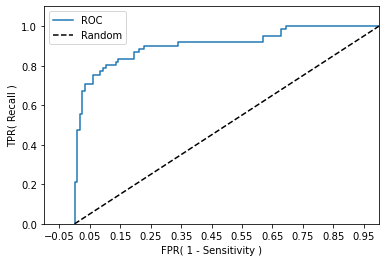

In [99]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(-0.1,1); plt.ylim(0,1.1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )


In [230]:
from sklearn.metrics import roc_auc_score

### 아래는 roc_auc_score()의 인자를 잘못 입력한 것으로, 책에서 수정이 필요한 부분입니다. 
### 책에서는 roc_auc_score(y_test, pred)로 예측 타겟값을 입력하였으나 
### roc_auc_score(y_test, y_score)로 y_score는 predict_proba()로 호출된 예측 확률 ndarray중 Positive 열에 해당하는 ndarray입니다. 

#pred = lr_clf.predict(X_test)
#roc_score = roc_auc_score(y_test, pred)

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))


ROC AUC 값: 0.9072


In [237]:
# pred 결과반환 1 - 0 - 1 - 0
# pred_proba 확률반환 55,45 - 60,40 - 38,62 
#ROC만 pred_proba사용

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test ,pred,pred_proba)

오차 행렬
[[108  10]
 [ 15  46]]
정확도: 0.8603, 정밀도: 0.8214, 재현율: 0.7541, F1: 0.7863, AUC:0.9072
